In [1]:
import os 
import glob 
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing

## Read data:
From Reza snippet

In [2]:
# Load raw data
raw = np.load('mouse_brain_ISH_float32.npz', allow_pickle=True)
data0 = raw['data']
sections = raw['sections'].item()

original_shape = data0.shape
data_size = data0.shape[1] * data0.shape[2] * data0.shape[3]

# reshaped data 
data = np.reshape(data0, (data0.shape[0], data_size))
gene_names_in_dataset = np.array(list(sections.values())) 

n_genes, n_cubes = data.shape

In [3]:
print(type(raw))
print(len(raw))
#print(raw.shape)


<class 'numpy.lib.npyio.NpzFile'>
2


In [3]:
print(type(data0))
print(data0.shape)
print(len(data0))
print(data0)

<class 'numpy.ndarray'>
(4345, 67, 41, 58)
4345
[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  ...

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]

  [[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1.

In [4]:
print(type(data))
print(data.shape)
print(len(data))
print(data)

<class 'numpy.ndarray'>
(4345, 159326)
4345
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [5]:
print(type(gene_names_in_dataset))
print(gene_names_in_dataset.shape)
print(len(gene_names_in_dataset))
print(gene_names_in_dataset)

<class 'numpy.ndarray'>
(4345,)
4345
['Inpp5a' 'Snap47' 'Nvl' ... 'Nkain4' 'Eno2' 'Car12']


In [7]:
i = 4344
d = data0[i]#[40][30][30]
print(d.shape)
#d

(67, 41, 58)


### cartesian product function
from 
https://stackoverflow.com/questions/45422898/how-can-i-efficiently-convert-a-4d-numpy-array-into-a-pandas-dataframe-with-indi

In [3]:
import functools

def cartesian_product_transpose(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.find_common_type([arr.dtype for arr in broadcasted], [])
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T



### Forming df
From Abe snippet

In [4]:
df = pd.DataFrame(data)

df.columns = ['cube_' + str(c) for c in df.columns.to_list()]

df['gene_name']=gene_names_in_dataset

## remove duplicated genes 
df_no_duplicate = df.drop_duplicates(subset='gene_name',keep='first')
df_no_duplicate = df_no_duplicate.set_index('gene_name')

df = df.set_index('gene_name')


### adding x,y,z of cubes 

xyzcubes = pd.DataFrame(cartesian_product_transpose(*[np.arange(i) for i in data0.shape[1:]]),
                  columns=[ 'x', 'y', 'z']).T ## transpose to make it consistent w/ df
xyzcubes.columns = df_no_duplicate.columns
# df_no_duplicate = df_no_duplicate.append(xyzcubes) this will add xyz to the end of df
df_no_duplicate = pd.concat([xyzcubes, df_no_duplicate])

### replace -1 expression values by NaN
df_no_duplicate[df_no_duplicate == -1]=np.nan

df_no_duplicate

,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_159316,cube_159317,cube_159318,cube_159319,cube_159320,cube_159321,cube_159322,cube_159323,cube_159324,cube_159325
x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
z,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0
Inpp5a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Snap47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gsn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sptssa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nkain4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eno2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Count number of NaNs & non-missing data:

In [9]:
total_elements = (df_no_duplicate.shape[0]-3)*df_no_duplicate.shape[1]
total_nan = df_no_duplicate.isna().sum().sum()
total_data = total_elements - total_nan
print(total_elements , total_nan, total_data, total_data/total_elements )
# print(pd.show_versions())
# a = pd.__version__
# type(a)

NameError: name 'df_no_duplicate' is not defined

### Dropping voxels with missing data depending on threshold

##### Test how .dropna method works

In [42]:
## test on how pd.dropna works
np.random.seed(123)
dff = pd.DataFrame((np.random.randn(10,4)*100).round(1), columns=list('ABCD'))
dff.iloc[3,0] = np.nan
dff.iloc[6,1] = np.nan
dff.iloc[5:8,2] = np.nan
dff.loc[4,'B'] = np.nan
dff.loc[3:,'D'] = np.nan
dff['ruhrowind'] = list('poiuytrewv')
dff = dff.set_index('ruhrowind')
dff.to_csv('testWrite_nan.txt', sep = '\t') #, index = False)
readdff = pd.read_csv('testWrite_nan.txt', sep = '\t')
readdff  = readdff.set_index('ruhrowind')
print('dff == readdff?? ',dff.equals(readdff))
dff


dff == readdff??  True


,A,B,C,D
ruhrowind,,,,
p,-108.6,99.7,28.3,-150.6
o,-57.9,165.1,-242.7,-42.9
i,126.6,-86.7,-67.9,-9.5
u,NaN,-63.9,-44.4,NaN
y,220.6,NaN,100.4,NaN
t,73.7,149.1,NaN,NaN
r,-125.4,NaN,NaN,NaN
e,-14.0,-86.2,NaN,NaN
w,-177.2,-70.0,92.7,NaN


KeyError: "None of ['ruhrowind'] are in the columns"

True

In [12]:
dff.dropna(thresh=3+1 , axis=1)

,A,B,C
0,-108.6,99.7,28.3
1,-57.9,165.1,-242.7
2,126.6,-86.7,-67.9
3,NaN,-63.9,-44.4
4,220.6,NaN,100.4
5,73.7,149.1,NaN
6,-125.4,NaN,NaN
7,-14.0,-86.2,NaN
8,-177.2,-70.0,92.7
9,0.3,68.8,-88.0


In [11]:
##! thresh = w ==> at least w non-NaN (non-missing) elements must exist along the selected axis(=1, eg) to keep the column. 
##! => If the number of NaNs in a column > len(df)-thresh ==> that column will be dropped

threshold = 3 + 1 # drops columns (voxels) with all expressions = -1 (=edge voxels) (first 3 rows = x,y,z)--> keeps columns with at least ONE non-missing XP value


#threshold = (len(df_noDup_noNaN) - 3)/2 # at least half of the XP values per column must be non-missing for the column to be kept

p = .8 ## at least p*100% of the expression values per columns (i.e. per voxel) must be non-missing for the column (ie. voxel) to be kept
threshold = (len(df_no_duplicate) - 3)*p

df_noDup_noNaN = df_no_duplicate.dropna(thresh=threshold, axis=1)

df_noDup_noNaN




,cube_22175,cube_22176,cube_22177,cube_22178,cube_22179,cube_22180,cube_22181,cube_22182,cube_22183,cube_22184,...,cube_156399,cube_156400,cube_156401,cube_156402,cube_156403,cube_156404,cube_156405,cube_156406,cube_156407,cube_156408
x,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
y,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
z,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,...,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
Inpp5a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007442,0.005156,0.007691,0.015266,0.017820,0.017653,0.012622,0.004253,0.000819,0.000207
Snap47,0.032842,0.068117,0.080820,0.088989,0.104787,0.104866,0.093827,0.079409,0.057083,0.031814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gsn,0.003602,0.004107,0.004546,0.005520,0.005561,0.004697,0.003984,0.003424,0.002259,0.002186,...,0.072132,0.069130,0.069565,0.071825,0.074829,0.068431,0.048244,0.025069,0.009485,0.002383
Sptssa,0.000315,0.000404,0.000450,0.000584,0.000663,0.000755,0.000957,0.000693,0.000288,0.000474,...,0.000582,0.000933,0.002139,0.002793,0.001985,0.000988,0.000666,0.000491,0.000191,0.000030
Nkain4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020428,0.026971,0.031260,0.031253,0.030276,0.029380,0.031874,0.037744,0.038002,0.026287
Eno2,0.122243,0.124465,0.129485,0.140176,0.153078,0.159892,0.159895,0.152830,0.117135,0.042064,...,0.128210,0.140179,0.145267,0.143166,0.133031,0.148761,0.144753,0.136376,0.111973,0.040796


### Normalization

In [ ]:
df_norm_noDup_noNaN = df_noDup_noNaN.iloc[3:,:].apply(lambda x: (x - x.mean())/x.std(), axis=1) ## z-norm excluding xyz
df_norm_noDup_noNaN = pd.concat([df_noDup_noNaN.iloc[:3,:], df_norm_noDup_noNaN]) ## adding x,y,z
df_norm_noDup_noNaN



In [103]:
df_norm_noDup_noNaN.to_csv('df_norm_NoDup_p.1NoNaN_NoEdgeVoxel.txt', sep = '\t')

In [69]:

# z-score normalization 
# df_norm_nodup = dftt.apply(lambda x: (x - x.mean())/x.std(), axis=1)
dftt.notna()
a = np.array(dftt)
a = a[pd.notna(a)] ##--> shows non-missing (non-NaN) values


dftt_norm = dftt.apply(lambda x: (x - x.mean())/x.std(), axis=1)
b = np.array(dftt_norm)
b = b[pd.notna(b)] ##--> shows non-missing (non-NaN) values
print(len(a),len(b))


4994

In [72]:
print(len(a),len(b))
print(dftt.shape, dftt_norm.shape)
b

5251 4994
(4082, 10) (4082, 10)


array([-1.16948686, -1.11780433, -0.94399235, ...,  0.00806291,
        2.37522499,  1.2239183 ])

In [43]:
list('ABC')
list('123134djfgw')
a= list(xyzcubes)
type(a)
len(a)
type(xyzcubes)
a = list(df_no_duplicate)
a = list(data)
a
# type(a)

[array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32),
 array([-1., -1., -1., ..., -1., -1., -1

In [ ]:
df_no_duplicate.count(axis=0)#.unique()

In [308]:
# df_no_duplicate.set_index('cube_0')#.count(level='cube_0')
print(df_no_duplicate[df_no_duplicate.cube_0 == -1].shape)

df_no_duplicate.loc['Inpp5a']==-1

(4082, 159326)


cube_0         True
cube_1         True
cube_2         True
cube_3         True
cube_4         True
               ... 
cube_159321    True
cube_159322    True
cube_159323    True
cube_159324    True
cube_159325    True
Name: Inpp5a, Length: 159326, dtype: bool

In [272]:
xx = df_no_duplicate.dropna(axis=1, how='all')

In [280]:
xx['cube_1480'].unique()
# df_no_duplicate
# xx

array([       nan, 0.00882135, 0.0014129 , 0.02663902, 0.00111134,
       0.00217962], dtype=float32)

In [185]:
df_no_duplicate = df_no_duplicate.append(xyzcubes)


,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_159316,cube_159317,cube_159318,cube_159319,cube_159320,cube_159321,cube_159322,cube_159323,cube_159324,cube_159325
x,0,0,0,0,0,0,0,0,0,0,...,66,66,66,66,66,66,66,66,66,66
y,0,0,0,0,0,0,0,0,0,0,...,40,40,40,40,40,40,40,40,40,40
z,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57


In [188]:
df_no_duplicate

,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_159316,cube_159317,cube_159318,cube_159319,cube_159320,cube_159321,cube_159322,cube_159323,cube_159324,cube_159325
gene_name,,,,,,,,,,,,,,,,,,,,,
Inpp5a,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Snap47,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Nvl,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Gtf3c2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Acadl,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gsn,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Sptssa,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Nkain4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 1. cartesian product: forming detailed df

In [4]:
import numpy as np
import pandas as pd
import functools

ngene = data0.shape[0]
xdim = data0.shape[1]
ydim = data0.shape[2]
zdim = data0.shape[3]


def cartesian_product_transpose(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.find_common_type([arr.dtype for arr in broadcasted], [])
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

df_cart_prod = pd.DataFrame(cartesian_product_transpose(*[np.arange(i) for i in data0.shape]),
                  columns=['gene', 'x', 'y', 'z'])
df_cart_prod['val'] = data0.ravel()
df_cart_prod

,gene,x,y,z,val
0,0,0,0,0,-1.0
1,0,0,0,1,-1.0
2,0,0,0,2,-1.0
3,0,0,0,3,-1.0
4,0,0,0,4,-1.0
...,...,...,...,...,...
692271465,4344,66,40,53,-1.0
692271466,4344,66,40,54,-1.0
692271467,4344,66,40,55,-1.0
692271468,4344,66,40,56,-1.0


In [5]:
df_cart_prod['val'].describe()

count    6.922715e+08
mean    -3.923658e-01
std      4.990459e-01
min     -1.000000e+00
25%     -1.000000e+00
50%      1.771805e-06
75%      3.565328e-03
max      8.173691e-01
Name: val, dtype: float64

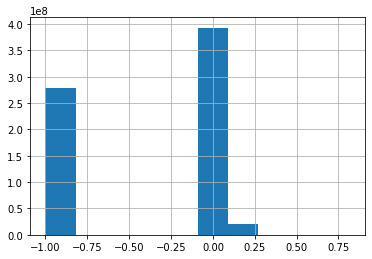

In [12]:

df_cart_prod['val'].hist()

In [5]:
df_brain_cart_prod = df_cart_prod[df_cart_prod['val']!=-1.]

In [6]:
df_brain_cart_prod.shape

(413829671, 5)

In [8]:
df_brain_cart_prod['val'].describe()

count    4.138297e+08
mean     1.647619e-02
std      3.221787e-02
min      0.000000e+00
25%      4.178404e-05
50%      1.602142e-03
75%      1.582663e-02
max      8.173691e-01
Name: val, dtype: float64

In [7]:
df_brain_cart_prod

,gene,x,y,z,val
26753,0,11,10,15,5.526456e-08
26754,0,11,10,16,7.955019e-07
26755,0,11,10,17,6.681237e-06
26756,0,11,10,18,3.768037e-05
26757,0,11,10,19,1.136593e-04
...,...,...,...,...,...
692271044,4344,66,33,38,2.610344e-05
692271045,4344,66,33,39,2.327417e-06
692271046,4344,66,33,40,1.613613e-07
692271047,4344,66,33,41,8.661952e-09


In [11]:
df_brain_cart_prod.loc[:,'x_str'] = df_brain_cart_prod.loc[:,'x'].apply(str)
df_brain_cart_prod.loc[:,'y_str'] = df_brain_cart_prod.loc[:,'y'].apply(str)
df_brain_cart_prod.loc[:,'z_str'] = df_brain_cart_prod.loc[:,'z'].apply(str)


df_brain_cart_prod.loc[:,'xyz'] = df_brain_cart_prod.loc[:,'x_str'] + df_brain_cart_prod.loc[:,'y_str'] +df_brain_cart_prod.loc[:,'z_str'] 

df_brain_cart_prod_uniqxyz = df_brain_cart_prod.drop_duplicates(subset = ['xyz'])

df_brain_cart_prod_uniqxyz


/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,gene,x,y,z,val,x_str,y_str,z_str,xyz
26753,0,11,10,15,5.526456e-08,11,10,15,111015
26754,0,11,10,16,7.955019e-07,11,10,16,111016
26755,0,11,10,17,6.681237e-06,11,10,17,111017
26756,0,11,10,18,3.768037e-05,11,10,18,111018
26757,0,11,10,19,1.136593e-04,11,10,19,111019
...,...,...,...,...,...,...,...,...,...
630454916,3957,0,33,20,0.000000e+00,0,33,20,03320
630454917,3957,0,33,21,0.000000e+00,0,33,21,03321
630454918,3957,0,33,22,3.614750e-12,0,33,22,03322
630454919,3957,0,33,23,6.132016e-11,0,33,23,03323


In [12]:
df_brain_cart_prod

,gene,x,y,z,val,x_str,y_str,z_str,xyz
26753,0,11,10,15,5.526456e-08,11,10,15,111015
26754,0,11,10,16,7.955019e-07,11,10,16,111016
26755,0,11,10,17,6.681237e-06,11,10,17,111017
26756,0,11,10,18,3.768037e-05,11,10,18,111018
26757,0,11,10,19,1.136593e-04,11,10,19,111019
...,...,...,...,...,...,...,...,...,...
692271044,4344,66,33,38,2.610344e-05,66,33,38,663338
692271045,4344,66,33,39,2.327417e-06,66,33,39,663339
692271046,4344,66,33,40,1.613613e-07,66,33,40,663340
692271047,4344,66,33,41,8.661952e-09,66,33,41,663341


NameError: name 'df_brain_cart_prod_uniqxyz' is not defined

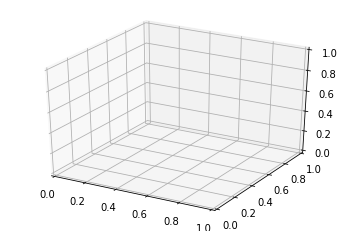

In [13]:
import mpl_toolkits.mplot3d as mp3
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_brain_cart_prod_uniqxyz.x, df_brain_cart_prod_uniqxyz.y, df_brain_cart_prod_uniqxyz.z)

## 1. END of cartesian product: forming detailed df

In [261]:
import numpy as np
import pandas as pd
import functools
import random
import string



random.seed(123)
mylet = string.ascii_letters


genes = np.array(['aa', 'bb', 'cc'])
ngene = len(genes)
xdim = 6
ydim = 4
zdim = 5
dd0 = np.full((ngene, xdim, ydim, zdim), -1)

n = 0
ng = 0
for g in genes:
    for i in range(dd0.shape[1]):
        for j in range(dd0.shape[2]):
            for k in range(dd0.shape[3]):
                #dd0.append([i,j,k])
                
                    #g = random.choice(mylet)
                    dd0[ng,i,j,k] = -n #float(n) #+ 0.1 ##???? doesnt show the floating result?? why?
#                     if i==0:
#                         dd0[ng,i,j,k] = 0
                    n += 1
    ng += 1
dd0 = np.array(dd0) 

# dd0 = np.array((ngene, xdim, ydim, zdim))
# dd0 = np.arange(dd0.prod()).reshape(dd0)


dd = np.reshape(dd0, (dd0.shape[0], dd0.shape[1]*dd0.shape[2]*dd0.shape[3]))
myxyz = pd.DataFrame(cartesian_product_transpose(*[np.arange(i) for i in dd0.shape[1:]]),
                  columns=[ 'x', 'y', 'z'])

print('dd0 : ',type(dd0))
print(dd0.shape)
print(len(dd0))

print('dd:', type(dd))
print(dd.shape)
print(len(dd))

print('genes:', type(genes))
print(genes.shape)
print(len(genes))
print(genes)

ddf = pd.DataFrame(dd)

ddf.columns = ['cube_' + str(c) for c in ddf.columns.to_list()]

ddf['gene_name']=genes
ddf = ddf.set_index('gene_name')

print('ddf:', type(ddf))
print(ddf.shape)
print(len(ddf))
#print(ddf)





def cartesian_product_transpose(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.find_common_type([arr.dtype for arr in broadcasted], [])
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

dd0f = pd.DataFrame(cartesian_product_transpose(*[np.arange(i) for i in dd0.shape]),
                  columns=['Ngene', 'x', 'y', 'z'])
dd0f['val'] = dd0.ravel()
dd0f['genename'] = np.nan
dd0f.loc[:,'genename'] = genes[dd0f.loc[:,'Ngene'] ]
dd0f = dd0f.set_index('genename')

print('dd0f:', type(dd0f))
print(dd0f.shape)
print(len(dd0f))
#print(dd0f)



print('dd0 : ',dd0)
print('__________________________________________')
print('dd: ',dd)




dd0 :  <class 'numpy.ndarray'>
(3, 6, 4, 5)
3
dd: <class 'numpy.ndarray'>
(3, 120)
3
genes: <class 'numpy.ndarray'>
(3,)
3
['aa' 'bb' 'cc']
ddf: <class 'pandas.core.frame.DataFrame'>
(3, 120)
3
dd0f: <class 'pandas.core.frame.DataFrame'>
(360, 5)
360
dd0 :  [[[[   0   -1   -2   -3   -4]
   [  -5   -6   -7   -8   -9]
   [ -10  -11  -12  -13  -14]
   [ -15  -16  -17  -18  -19]]

  [[ -20  -21  -22  -23  -24]
   [ -25  -26  -27  -28  -29]
   [ -30  -31  -32  -33  -34]
   [ -35  -36  -37  -38  -39]]

  [[ -40  -41  -42  -43  -44]
   [ -45  -46  -47  -48  -49]
   [ -50  -51  -52  -53  -54]
   [ -55  -56  -57  -58  -59]]

  [[ -60  -61  -62  -63  -64]
   [ -65  -66  -67  -68  -69]
   [ -70  -71  -72  -73  -74]
   [ -75  -76  -77  -78  -79]]

  [[ -80  -81  -82  -83  -84]
   [ -85  -86  -87  -88  -89]
   [ -90  -91  -92  -93  -94]
   [ -95  -96  -97  -98  -99]]

  [[-100 -101 -102 -103 -104]
   [-105 -106 -107 -108 -109]
   [-110 -111 -112 -113 -114]
   [-115 -116 -117 -118 -119]]]


 [[[-120

In [130]:
dd0.shape[1:]

(6, 4, 5)

In [219]:
pd.concat([ddf, myxyz.T])
# ddf.append()
type(myxyz.T)
type(ddf)
#ddf.append(np.array(myxyz.T), ignore_index=True)


# tt = pd.DataFrame({'Region':['West','North','South'],
#                    'Company':['Costco','Walmart','Home Depot'],
#                    'Product':['Dinner Set','Grocery','Gardening tools'],
#                    'Month':['September','July','February'],
#                    'Sales':[2500,3096,8795]})
# tt

# ttd = [{'Region':'East','Company':'Shop Rite','Product':'Fruits','Month':'December','Sales': 1265}]
# type(ttd)
# # list(myxyz.T)
# ttd
# np.array(myxyz.T).shape
type(myxyz.T)
tt = myxyz.T
#ddf.iloc[4:7,:] = tt
# tt.columns =  ['cube_' + str(c) for c in tt.columns.to_list()]
tt.columns = ddf.columns
# tt.append(ddf.iloc[1,:], ignore_index = True)
ddf.append(tt)

,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_110,cube_111,cube_112,cube_113,cube_114,cube_115,cube_116,cube_117,cube_118,cube_119
aa,NaN,NaN,NaN,NaN,NaN,-5,-6,-7,-8,-9,...,-110,-111,-112,-113,-114,-115,-116,-117,-118,-119
bb,-120.0,-121.0,-122.0,-123.0,-124.0,-125,-126,-127,-128,-129,...,-230,-231,-232,-233,-234,-235,-236,-237,-238,-239
cc,-240.0,-241.0,-242.0,-243.0,-244.0,-245,-246,-247,-248,-249,...,-350,-351,-352,-353,-354,-355,-356,-357,-358,-359
x,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
y,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,...,2,2,2,2,2,3,3,3,3,3
z,0.0,1.0,2.0,3.0,4.0,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4


In [256]:
ddf


,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_110,cube_111,cube_112,cube_113,cube_114,cube_115,cube_116,cube_117,cube_118,cube_119
gene_name,,,,,,,,,,,,,,,,,,,,,
aa,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,...,-110,-111,-112,-113,-114,-115,-116,-117,-118,-119
bb,-120,-121,-122,-123,-124,-125,-126,-127,-128,-129,...,-230,-231,-232,-233,-234,-235,-236,-237,-238,-239
cc,-240,-241,-242,-243,-244,-245,-246,-247,-248,-249,...,-350,-351,-352,-353,-354,-355,-356,-357,-358,-359


In [266]:
# ddf.columns[ddf['cube_5']>-5]
# ddf['cube_5']
aa = ddf[ddf < -5 ]#[ddf < -120] 
# ddf
aa
ddf[ddf == -1]=np.nan
ddf

df_no_duplicate[df_no_duplicate == -1]=np.nan

In [76]:
dd0f

,Ngene,x,y,z,val
genename,,,,,
aa,0,0,0,0,0
aa,0,0,0,1,-1
aa,0,0,0,2,-2
aa,0,0,0,3,-3
aa,0,0,0,4,-4
...,...,...,...,...,...
cc,2,5,3,0,-355
cc,2,5,3,1,-356
cc,2,5,3,2,-357


In [71]:
dd0f.loc['aa'].iloc[:,4].iloc[1]

-2

In [39]:
dd0f['x_str'] = dd0f['x'].apply(str)
dd0f['y_str'] = dd0f['y'].apply(str)
dd0f['z_str'] = dd0f['z'].apply(str)

# dd0f['x_str'].apply(str)
# dd0f['y_str'].apply(str)
# dd0f['z_str'].apply(str)

dd0f['xyz'] = dd0f['x_str'] + dd0f['y_str'] +dd0f['z_str'] 

dd0f_uniqxyz = dd0f.drop_duplicates(subset = ['xyz'])
dd0f

,Ngene,x,y,z,val,x_str,y_str,z_str,xyz
0,0,0,0,0,-1,0,0,0,000
1,0,0,0,1,-2,0,0,1,001
2,0,0,0,2,-3,0,0,2,002
3,0,0,0,3,-4,0,0,3,003
4,0,0,0,4,-5,0,0,4,004
...,...,...,...,...,...,...,...,...,...
355,2,5,3,0,-356,5,3,0,530
356,2,5,3,1,-357,5,3,1,531
357,2,5,3,2,-358,5,3,2,532
358,2,5,3,3,-359,5,3,3,533


In [40]:
dd0f_uniqxyz

,Ngene,x,y,z,val,x_str,y_str,z_str,xyz
0,0,0,0,0,-1,0,0,0,000
1,0,0,0,1,-2,0,0,1,001
2,0,0,0,2,-3,0,0,2,002
3,0,0,0,3,-4,0,0,3,003
4,0,0,0,4,-5,0,0,4,004
...,...,...,...,...,...,...,...,...,...
115,0,5,3,0,-116,5,3,0,530
116,0,5,3,1,-117,5,3,1,531
117,0,5,3,2,-118,5,3,2,532
118,0,5,3,3,-119,5,3,3,533


In [75]:
dd0f.to_csv(path_or_buf='dd0f.txt', sep = '\t' )

In [22]:
print(dd.shape)
[print(i) for i in dd.shape]

(3, 120)
3
120


[None, None]

In [34]:
print(np.arange(9))
kk = [np.arange(i) for i in dd.shape]


print(type(kk))
print(len(kk))
print(kk)
print(type(kk[0]))

rr = dd0.ravel()
print('this is how ravel works: ',type(rr),rr.shape, len(rr),  rr)

[np.arange(i) for i in dd0.shape]

[0 1 2 3 4 5 6 7 8]
<class 'list'>
2
[array([0, 1, 2]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])]
<class 'numpy.ndarray'>
this is how ravel works:  <class 'numpy.ndarray'> (360,) 360 [  -1   -2   -3   -4   -5   -6   -7   -8   -9  -10  -11  -12  -13  -14
  -15  -16  -17  -18  -19  -20  -21  -22  -23  -24  -25  -26  -27  -28
  -29  -30  -31  -32  -33  -34  -35  -36  -37

[array([0, 1, 2]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3, 4])]

In [452]:
import random
import string



random.seed(123)
mylet = string.ascii_letters


ngene = 2
xdim = 6
ydim = 4
zdim = 5
dd = np.full((ngene, xdim, ydim, zdim), -1)

n = 0
for g in range(ngene):
    for i in range(dd.shape[1]):
        for j in range(dd.shape[2]):
            for k in range(dd.shape[3]):
                #dd.append([i,j,k])
                
                    #g = random.choice(mylet)
                    dd[g,i,j,k] = -n #float(n) #+ 0.1 ##???? doesnt show the floating result?? why?
                    n += 1

dd = np.array(dd) 


ddict = {col: [] for col in ['gene', 'x', 'y', 'z', 'val']}
for i, val in np.ndenumerate(dd):
    ddict['gene'].append(i[0])
    ddict['x'].append(i[1])
    ddict['y'].append(i[2])
    ddict['z'].append(i[3])
    ddict['val'].append(val)

ddf = pd.DataFrame(ddict)
print(dd.shape)
print(dd.size)
print(len(dd))
ddf




(2, 6, 4, 5)
240
2


,gene,x,y,z,val
0,0,0,0,0,0
1,0,0,0,1,-1
2,0,0,0,2,-2
3,0,0,0,3,-3
4,0,0,0,4,-4
...,...,...,...,...,...
235,1,5,3,0,-235
236,1,5,3,1,-236
237,1,5,3,2,-237
238,1,5,3,3,-238


In [453]:
dd

array([[[[   0,   -1,   -2,   -3,   -4],
         [  -5,   -6,   -7,   -8,   -9],
         [ -10,  -11,  -12,  -13,  -14],
         [ -15,  -16,  -17,  -18,  -19]],

        [[ -20,  -21,  -22,  -23,  -24],
         [ -25,  -26,  -27,  -28,  -29],
         [ -30,  -31,  -32,  -33,  -34],
         [ -35,  -36,  -37,  -38,  -39]],

        [[ -40,  -41,  -42,  -43,  -44],
         [ -45,  -46,  -47,  -48,  -49],
         [ -50,  -51,  -52,  -53,  -54],
         [ -55,  -56,  -57,  -58,  -59]],

        [[ -60,  -61,  -62,  -63,  -64],
         [ -65,  -66,  -67,  -68,  -69],
         [ -70,  -71,  -72,  -73,  -74],
         [ -75,  -76,  -77,  -78,  -79]],

        [[ -80,  -81,  -82,  -83,  -84],
         [ -85,  -86,  -87,  -88,  -89],
         [ -90,  -91,  -92,  -93,  -94],
         [ -95,  -96,  -97,  -98,  -99]],

        [[-100, -101, -102, -103, -104],
         [-105, -106, -107, -108, -109],
         [-110, -111, -112, -113, -114],
         [-115, -116, -117, -118, -119]]],


  

In [454]:
np.reshape(dd, (dd.shape[0], dd.shape[1]*dd.shape[2]*dd.shape[3]))


array([[   0,   -1,   -2,   -3,   -4,   -5,   -6,   -7,   -8,   -9,  -10,
         -11,  -12,  -13,  -14,  -15,  -16,  -17,  -18,  -19,  -20,  -21,
         -22,  -23,  -24,  -25,  -26,  -27,  -28,  -29,  -30,  -31,  -32,
         -33,  -34,  -35,  -36,  -37,  -38,  -39,  -40,  -41,  -42,  -43,
         -44,  -45,  -46,  -47,  -48,  -49,  -50,  -51,  -52,  -53,  -54,
         -55,  -56,  -57,  -58,  -59,  -60,  -61,  -62,  -63,  -64,  -65,
         -66,  -67,  -68,  -69,  -70,  -71,  -72,  -73,  -74,  -75,  -76,
         -77,  -78,  -79,  -80,  -81,  -82,  -83,  -84,  -85,  -86,  -87,
         -88,  -89,  -90,  -91,  -92,  -93,  -94,  -95,  -96,  -97,  -98,
         -99, -100, -101, -102, -103, -104, -105, -106, -107, -108, -109,
        -110, -111, -112, -113, -114, -115, -116, -117, -118, -119],
       [-120, -121, -122, -123, -124, -125, -126, -127, -128, -129, -130,
        -131, -132, -133, -134, -135, -136, -137, -138, -139, -140, -141,
        -142, -143, -144, -145, -146, -147,

In [425]:
pd.DataFrame.equals(df,ddf)

True

In [395]:
p = 1
for i in range(1,13):
    print(i)
    p = p*i
p == dd.prod()

1
2
3
4
5
6
7
8
9
10
11
12


True

In [319]:
dd[0,0,1,:]

array([-5, -6, -7, -8, -9])

In [281]:
dd

array([[[[  0,   1,   2,   3,   4],
         [  5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14],
         [ 15,  16,  17,  18,  19]],

        [[ 20,  21,  22,  23,  24],
         [ 25,  26,  27,  28,  29],
         [ 30,  31,  32,  33,  34],
         [ 35,  36,  37,  38,  39]],

        [[ 40,  41,  42,  43,  44],
         [ 45,  46,  47,  48,  49],
         [ 50,  51,  52,  53,  54],
         [ 55,  56,  57,  58,  59]],

        [[ 60,  61,  62,  63,  64],
         [ 65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74],
         [ 75,  76,  77,  78,  79]],

        [[ 80,  81,  82,  83,  84],
         [ 85,  86,  87,  88,  89],
         [ 90,  91,  92,  93,  94],
         [ 95,  96,  97,  98,  99]],

        [[100, 101, 102, 103, 104],
         [105, 106, 107, 108, 109],
         [110, 111, 112, 113, 114],
         [115, 116, 117, 118, 119]]],


       [[[120, 121, 122, 123, 124],
         [125, 126, 127, 128, 129],
         [130, 131, 132, 133, 134],
         [135,

In [332]:
ddf

,gene,x,y,z,val
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,0,2,2
3,0,0,0,3,3
4,0,0,0,4,4
...,...,...,...,...,...
235,1,5,3,0,235
236,1,5,3,1,236
237,1,5,3,2,237
238,1,5,3,3,238


In [433]:
4345* 67*41* 58

692271470

In [14]:
dd0.shape

(3, 6, 4, 5)

In [17]:
df

,ruhind
ind,
x,29
y,5
z,9


In [15]:
xyz = []
for k in range(10):#range(data0.shape[3]):
    for j in range(6):#range(data0.shape[2]):
        for i in range(30):#range(data0.shape[1]):
            df = pd.DataFrame({'ind':['x','y','z'] , 'ruhind':[i,j,k]}).set_index('ind')
            xyz.append(df)
xyz = pd.concat(xyz, axis=1).transpose()

AttributeError: 'DataFrame' object has no attribute 'x'

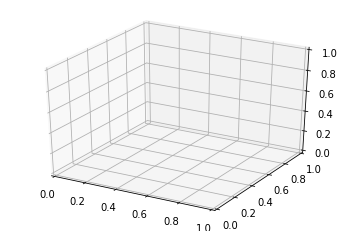

In [16]:
import mpl_toolkits.mplot3d as mp3
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df.x, df.y, df.z)

Row normalization:

https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization

In [3]:
df = pd.DataFrame(data)

df.columns = ['cube_' + str(c) for c in df.columns.to_list()]

df['gene_name']=gene_names_in_dataset

# remove duplicate genes 
df_no_duplicate = df.drop_duplicates(subset='gene_name',keep='first')
df_no_duplicate = df_no_duplicate.set_index('gene_name')

df = df.set_index('gene_name')


In [77]:
original_shape

(4345, 67, 41, 58)

In [79]:
dfspatia = data0.reshape(original_shape[1],original_shape[2],original_shape[3])

ValueError: cannot reshape array of size 692271470 into shape (67,41,58)

In [80]:
type(data0)

numpy.ndarray

In [81]:
data0.shape

(4345, 67, 41, 58)

159326

In [74]:
type(df)
# df.shape
df.tail()
data.shape
df.head()
df.cube_1222.value_counts()

-1.0    4345
Name: cube_1222, dtype: int64

In [54]:
df.shape

(4345, 159326)

In [64]:
df['Inpp5a'].value_counts(sort=True).head()

KeyError: 'Inpp5a'

In [63]:
df.columns['cube_0'].value_counts(sort=True).head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [50]:
type(sections)
# len(sections)
sections
type(raw)

numpy.lib.npyio.NpzFile

In [7]:
sections[73994713]

'Inpp5a'

In [27]:
type(df)
df.shape
type(data0)
#data0.shape
#data0.head()
data0[:10]
original_shape
data0[1,1]
ddd = [[12,453,356,'fgf'],[87,'fgkj',23423]]
type(ddd)
students = [           
    ["Popeye", 24],  
    ["Tabatha", 23], 
    ["Jerry", 25],
    ["Flynn", 23],    
    ["Sally", 40],
    ["Michael", 46],
    ["Susie", 19],
    ["Amanda", 34]
] 

for i,j in enumerate(students):
    #for j in i:
        print(i,j)


0 ['Popeye', 24]
1 ['Tabatha', 23]
2 ['Jerry', 25]
3 ['Flynn', 23]
4 ['Sally', 40]
5 ['Michael', 46]
6 ['Susie', 19]
7 ['Amanda', 34]


In [40]:
data0[1,45,30,50]

0.025389647

In [42]:
ruhdf = pd.DataFrame(data0[1,:,30,50])
# ruhdf

,0
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
62,-1.0
63,-1.0
64,-1.0
65,-1.0


# Test normalization wrt axis 0 & 1:

In [36]:

d = {'col1': [1, 234, 12, -34324], 'col2': [123, 667, 987, 23], 'col3': [908, 122, 3543, 651243], 'col4': [34, 458, 1256, -4023]}
dftest = pd.DataFrame(d)
dftest

,col1,col2,col3,col4
0,1,123,908,34
1,234,667,122,458
2,12,987,3543,1256
3,-34324,23,651243,-4023


In [31]:
dftest_norm1 = dftest.apply(lambda x: (x - x.mean())/x.std(), axis=1)
dftest_norm1

## from R on elements of first row of dftest (= row '0'): this is equivalent to axis=1, i.e, 
## apply the function lambda on elements of COLUMNS: first element of each COLUMN (= 1st row), 
## then 2nd element of each COLUMN(=2nd ROW), etc
#[1,] -0.6163533
#[2,] -0.3331326
#[3,]  1.4892304
#[4,] -0.5397445

,col1,col2,col3,col4
0,-0.616353,-0.333133,1.489230,-0.539744
1,-0.562599,1.225331,-1.025066,0.362335
2,-0.961867,-0.309470,1.400813,-0.129476
3,-0.564305,-0.460963,1.498404,-0.473136


In [32]:
dftest_norm0 = dftest.apply(lambda x: (x - x.mean())/x.std(), axis=0)
dftest_norm0
##from R on first col of  dftest (= 'col1'): (i.e row-wise in Python, ie. axis = 0)
#[1,]  0.4952625
#[2,]  0.5088063
#[3,]  0.4959020
#[4,] -1.4999708

,col1,col2,col3,col4
0,0.495263,-0.716584,-0.501892,0.255630
1,0.508806,0.475531,-0.504312,0.435451
2,0.495902,1.176775,-0.493781,0.773888
3,-1.499971,-0.935723,1.499985,-1.464969


# End of test 

In [40]:
# z-score normalization 
df_norm = df.apply(lambda x: (x - x.mean())/x.std(), axis=1)

In [41]:
df_norm.head()

,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_159316,cube_159317,cube_159318,cube_159319,cube_159320,cube_159321,cube_159322,cube_159323,cube_159324,cube_159325
gene_name,,,,,,,,,,,,,,,,,,,,,
Inpp5a,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,...,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203
Snap47,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,...,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063
Nvl,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,...,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214
Gtf3c2,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,...,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794
Acadl,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,...,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485


In [42]:
df_norm.shape

(4345, 159326)

In [6]:
my_std = df_norm.apply(lambda x: x.std(), axis=1)

In [7]:
my_mean = df_norm.apply(lambda x: x.mean(), axis=1)

In [12]:
sum(my_std != 1)

1713

In [11]:
my_std.head()

gene_name
Inpp5a    1.0
Snap47    1.0
Nvl       1.0
Gtf3c2    1.0
Acadl     1.0
dtype: float64

In [12]:
my_std.shape

(4345,)

In [18]:
df_norm

,cube_0,cube_1,cube_2,cube_3,cube_4,cube_5,cube_6,cube_7,cube_8,cube_9,...,cube_159316,cube_159317,cube_159318,cube_159319,cube_159320,cube_159321,cube_159322,cube_159323,cube_159324,cube_159325
gene_name,,,,,,,,,,,,,,,,,,,,,
Inpp5a,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,...,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203,-1.135203
Snap47,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,...,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063,-1.101063
Nvl,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,...,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214,-1.046214
Gtf3c2,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,...,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794,-1.241794
Acadl,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,...,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485,-1.506485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gsn,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,...,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843,-1.607843
Sptssa,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,...,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941,-1.476941
Nkain4,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,...,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569,-1.300569


We need to write each cube's experssion profile into a file for running FIRE and iPAGE. Our data in this study is a huge data frame; Therefore, I'm performing a function to do this task in parallel as described [here](https://stackoverflow.com/questions/59184496/how-to-make-the-following-for-loop-use-multiple-core-in-python). 

> Regardless of the function your performing, for multiprocessing you:
> - Create a pool with your desired number of processors
> - Loop through your data in whatever way you want to chunk it
> - Create a job with that chunk (using `pool.apply_async()` <- read the docs about this if it's confusing)
> - Submit your jobs with `job.get()`
> - Combine your results

NO NO NO! 

The wheel has been invented for me: https://github.com/nalepae/pandarallel

Write FIRE inputs into files:

In [ ]:
for i in range(n_cubes): df_no_duplicate.iloc[:,i].to_csv(f'FIRE_inputs/cube_{i}.txt',sep='\t', header=True)

Write iPAGE inputs into files:

In [ ]:
for i in range(n_cubes): df.iloc[:,i].to_csv(f'iPAGE_inputs/cube_{i}.txt',sep='\t', header=False)

In [20]:
cat FIRE_inputs/cube_1.txt | head 

gene_name	cube_1
Inpp5a	-1.0
Snap47	-1.0
Nvl	-1.0
Gtf3c2	-1.0
Acadl	-1.0
Baiap3	-1.0
S100a6	-1.0
Clock	-1.0
Mageh1	-1.0


In [21]:
zip -r cube_1.zip FIRE_results/cube_1/ iPAGE_results/cube_1/

SyntaxError: invalid syntax (<ipython-input-21-345b8aea41d2>, line 1)

Let's check what we have already:

In [14]:
len (glob.glob('iPAGE_inputs/*.txt') )
# == n_cubes 

159326

In [ ]:
len (glob.glob('FIRE_inputs/*.txt') )
#  == n_cubes 

In [ ]:
len (glob.glob('FIRE_results/*') )
# == n_cubes 

In [13]:
import glob

len (glob.glob('iPAGE_results/*') )
# == n_cubes 

130936

## iPAGE

- https://www.gnu.org/software/bash/manual/html_node/GNU-Parallel.html
- https://www.gnu.org/software/parallel/parallel_tutorial.html#Multiple-input-sources

In [ ]:
# %%bash 
# nohup python -c "import glob; li=glob.glob('iPAGE_inputs/*.txt'); print ('\n'.join(li) )" | parallel -j18 -k bash ipage.sh {} &> ipage.out &

## FIRE

In [ ]:
# %%bash 
# nohup python -c "import glob; li=glob.glob('FIRE_inputs/*.txt'); print ('\n'.join(li) )" | parallel -j18 -k bash fire.sh {} &> fire.out &

Let's download mm10 fasta file from FIRE tutorial page - [link](https://tavazoielab.c2b2.columbia.edu/FIRE/tutorial.html).

### Restructuring FIRE sequence input for mouse gene names 

I found same note on Yikai's folder! 

https://github.com/johnnyUCSF/metastatic_evolution_regulators/blob/f4f940824e08ef2a3948478bcbbd94db4ade3174/FIRE/FIRE_README.txt

In [ ]:
def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def write_fasta(path, fa):
    file = open(path, 'w')
    for f in fa:
        file.write('>' + str(f) + '\n')
        file.write(fa[f] + '\n')
    file.close()



In [ ]:
refseq_df = pd.read_table(
    '~/genomes/pyensembl/GRCm38/ensembl100/Mus_musculus.GRCm38.100.refseq.tsv', index_col=0
) 

refseq2ens = pd.DataFrame([[ref,ens] for ens, ref in set(zip(refseq_df.index, refseq_df.xref))]).set_index(0)

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R 
library (GenomicFeatures)
library (tidyverse)

In [ ]:
%%R -o gene2name
GTF = '/rumi/shams/abe/genomes/pyensembl/GRCm38/ensembl100/Mus_musculus.GRCm38.100.gtf.gz'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

In [ ]:
refseq2ens = refseq2ens.assign(gene_name=gene2name.gene_name[refseq2ens.iloc[:,0] ].to_list() )

In [ ]:
def fasta_reheader(infa, outfa, refseq2ens=refseq2ens):
    seq = read_fasta(infa)
    refseq_ids = pd.Series([k for k in seq.keys()])

    new_header = refseq2ens.gene_name[
        # filter out missing refseq in annotation data 
        refseq_ids.loc[refseq_ids.isin(refseq2ens.index)].to_list()
    ].to_list()

    seq_by_gene_names = dict(zip(new_header , list(seq.values())) )

    seq_by_gene_names = {key: value for key, value in seq_by_gene_names.items() if len(value) < 10000} # < 10000bp 

    write_fasta(outfa, seq_by_gene_names)

    print (infa, '-> ', outfa)
    print ('fasta header converted from refseq to gene names!')

In [ ]:
%%R -o fasta_files
fasta_files = list.files('/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSE/SEQUENCES', pattern='.fa$')

In [ ]:
for infa in list(fasta_files):
    fasta_reheader(
        f'/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSE/SEQUENCES/{infa}',
        f'/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSENAME/SEQUENCES/{infa}'
    )

Using my `perl` environment

In [ ]:
%%bash 
for fa in /rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSENAME/SEQUENCES/*.fa; do 
#     formatdb -i $fa -p F -o T; 
    echo perl /rumi/shams/abe/Workflows/FIRE/TOOLS/detect_homologous_sequences.pl --fastafile=$fa; 
done

In [ ]:
cp -v /rumi/shams/abe/Workflows/FIRE/FIRE_DATA/SPECIES_DATA/mouse /rumi/shams/abe/Workflows/FIRE/FIRE_DATA/SPECIES_DATA/mouse_name

In [ ]:
%%bash 
p=/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSENAME/ANNOTATIONS/
cat ${p}mouse_gene_descriptions.txt | \
awk -F"\t" '{OFS=FS}$1=$2' > ${p}mouse_gene_by_name_descriptions.txt

In [ ]:
def read_write_go_index(goin, goout, refseq2ens=refseq2ens):
    fileI = open(goin)
    lines = [l.split('\t') for l in fileI.read().splitlines()]
    refseq_ids = pd.Series([l[0] for l in lines], dtype=str)
    GOs = [l[1:] for l in lines]
    
    refseq_ids = refseq2ens.gene_name[
        # filter out missing refseq in annotation data 
        refseq_ids.loc[refseq_ids.isin(refseq2ens.index)].to_list()
    ].to_list()

    GOs_by_gene_names = dict(zip(refseq_ids , GOs) )
    
    fileI.close()

    new_lines = [str(key) + "\t" + "\t".join(val) for key,val in GOs_by_gene_names.items()]
    
    # write 
    fileO = open(goout, 'w')
    for nl in new_lines:
        fileO.write( nl + '\n')
    
    fileO.close()
    


In [ ]:
read_write_go_index(
    '/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSE/ANNOTATIONS/mouse_go_index.txt',
    '/rumi/shams/abe/Workflows/FIRE/FIRE_DATA/MOUSENAME/ANNOTATIONS/mouse_go_index.txt'
)

In [ ]:
!perl /rumi/shams/abe/Workflows/FIRE/TOOLS/FIRE_analyse_input_files.pl -expfile temp1.txt

add `--jn_t-2`

## Downstream analysis 

1. write script to load iGET result in python 
2. 